# Project 1:
## CIFAR-10 Image Classification using CNNs

### Team Members

- **Dheeraj Rahul Reddy Piduru** – *DXP230050*  
- **Yoshinee Lingampalli** – *YXL230045*  
- **Jaahnavi Pothukanuri** – *JXP230058*


# Step 1: Data Exploration and Preprocessing



**Objective:**
Load and explore the CIFAR-10 dataset. CIFAR-10 consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. The dataset is divided into 50,000 training images and 10,000 test images.

**Dataset Description:**

• The data is stored in binary format and consists of multiple batches.

• Each image is represented as a 1D array of 3072 values (1024 for Red, Green, and Blue channels).

• The goal is to load the data correctly, decode the byte content, and extract the actual image arrays and corresponding labels.

**Tasks Performed:**

• Defined a custom unpickle function to load data from the .py batch files.

• Loaded all five training batches and one test batch from the dataset folder.

• Concatenated the training data from the five batches into a single array.

• Extracted the label names to map numerical labels to class names.




In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os

def unpickle(file):
    with open(file, 'rb') as fo:
        data_dict = pickle.load(fo, encoding='bytes')
    return data_dict

data_path = "U:\Deep Learning\Project 1\cifar-10-batches-py"

train_data = []
train_labels = []

for i in range(1, 6):
    batch = unpickle(os.path.join(data_path, f"data_batch_{i}"))
    train_data.append(batch[b'data'])
    train_labels += batch[b'labels']

train_data = np.concatenate(train_data)
train_labels = np.array(train_labels)

test_batch = unpickle(os.path.join(data_path, "test_batch"))
test_data = test_batch[b'data']
test_labels = np.array(test_batch[b'labels'])

meta = unpickle(os.path.join(data_path, "batches.meta"))
label_names = [label.decode('utf-8') for label in meta[b'label_names']]


<>:13: SyntaxWarning: invalid escape sequence '\D'
<>:13: SyntaxWarning: invalid escape sequence '\D'
C:\Users\dheer\AppData\Local\Temp\ipykernel_21768\1957084103.py:13: SyntaxWarning: invalid escape sequence '\D'
  data_path = "U:\Deep Learning\Project 1\cifar-10-batches-py"


### Visualizing classes

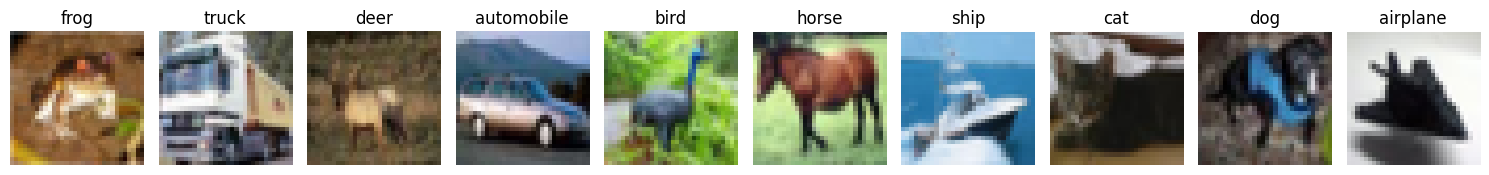

In [ ]:
def show_one_image_per_class(images, labels, class_names):
    shown = set()
    plt.figure(figsize=(15, 2))
    count = 0
    
    for idx in range(len(images)):
        label = labels[idx]
        if label not in shown:
            shown.add(label)
            img = images[idx].reshape(3, 32, 32).transpose(1, 2, 0)
            plt.subplot(1, 10, count + 1)
            plt.imshow(img)
            plt.title(class_names[label])
            plt.axis('off')
            count += 1
        
        if count == 10:
            break

    plt.tight_layout()
    plt.show()

show_one_image_per_class(train_data, train_labels, label_names)



### Class Distribution

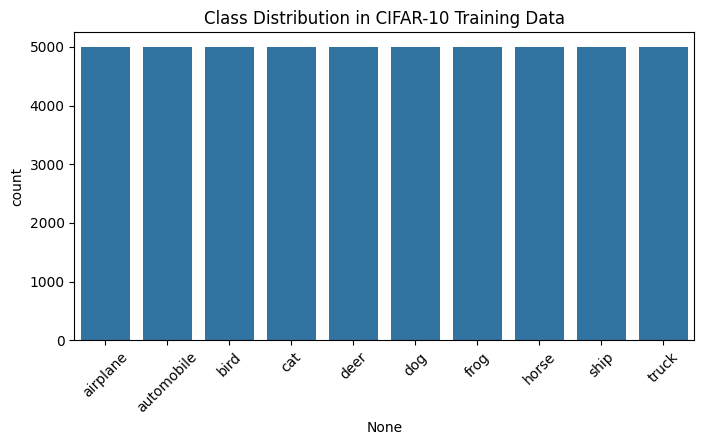

In [3]:
import seaborn as sns
import pandas as pd

label_series = pd.Series(train_labels)
plt.figure(figsize=(8, 4))
sns.countplot(x=label_series)
plt.title("Class Distribution in CIFAR-10 Training Data")
plt.xticks(ticks=np.arange(10), labels=label_names, rotation=45)
plt.show()


### **Extracted 10 class labels:**
### ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Normalize and Reshape

In [4]:
train_data = train_data.reshape(-1, 3, 32, 32).astype("float32") / 255.0
test_data = test_data.reshape(-1, 3, 32, 32).astype("float32") / 255.0


### Preprocessing

- **Reshaped the image data** from shape `(num_samples, 3072)` to `(num_samples, 3, 32, 32)`:
  - This format is required for PyTorch CNN models, where the channel dimension (RGB) comes first.
- **Normalized pixel values** to the range `[0, 1]` by dividing all values by 255:
  - This helps in faster and more stable training of neural networks by scaling features uniformly.


- Neural networks perform better when the input data is normalized, especially in image-related tasks.
- Reshaping ensures the data has the correct format to be passed through convolutional layers, which expect images in the form `[batch_size, channels, height, width]`.






### Splitting the Dataset


- **Split the training data into two subsets:**
  - **Training Set (90%)**
  - **Validation Set (10%)**
- Used `train_test_split` from `sklearn.model_selection` with:
  - `stratify=train_labels` to ensure balanced class distribution across the splits
  - `random_state=42` for reproducibility





In [5]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    train_data, train_labels, test_size=0.1, stratify=train_labels, random_state=42
)

print("Training Set:", X_train.shape)
print("Validation Set:", X_val.shape)
print("Test Set:", test_data.shape)


Training Set: (45000, 3, 32, 32)
Validation Set: (5000, 3, 32, 32)
Test Set: (10000, 3, 32, 32)


### **Dataset Overview After Splitting:**

| Dataset       | Shape               |
|---------------|---------------------|
| Training Set  | (45,000, 3, 32, 32) |
| Validation Set| (5,000, 3, 32, 32)  |
| Test Set      | (10,000, 3, 32, 32) |


# Step 2: Building a Basic CNN


## Define CNN Architecture (PyTorch)

### What We Have Done in This Step:

- Defined a simple **Convolutional Neural Network (CNN)** architecture using PyTorch's `nn.Module`.
- The architecture includes:
  - **Two convolutional layers (Conv2D)** to extract spatial features from the input images
  - **Two max-pooling layers (MaxPool2D)** to downsample feature maps and reduce computation
  - **Two fully connected layers**:
    - First FC layer with 128 units for feature combination
    - Output FC layer with 10 units for classification (CIFAR-10 has 10 classes)
- Used **ReLU activation functions** to introduce non-linearity.







In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)  

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = BasicCNN()
print(model)


BasicCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


## CNN Layer Explanation

### Conv2D Layers
- Extract spatial features from the input images.
- Early layers detect simple patterns (edges), deeper layers detect complex shapes.
- Padding is used to preserve spatial dimensions.

### MaxPooling2D
- Reduces the spatial resolution of feature maps.
- Helps decrease computation and adds translation invariance.

### Flatten
- Converts 3D feature maps into 1D vectors.
- Required for transitioning to fully connected layers.

### Dense (Fully Connected) Layers
- Learn class-specific feature combinations.
- The final dense layer outputs logits for the 10 CIFAR-10 classes.


## CNN architecture


In [21]:
from torchsummary import summary

model = BasicCNN().to(device)
summary(model, input_size=(3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
         MaxPool2d-2           [-1, 32, 16, 16]               0
            Conv2d-3           [-1, 64, 16, 16]          18,496
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Linear-5                  [-1, 128]         524,416
            Linear-6                   [-1, 10]           1,290
Total params: 545,098
Trainable params: 545,098
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.47
Params size (MB): 2.08
Estimated Total Size (MB): 2.56
----------------------------------------------------------------


## Loss Function and Optimizer


- Moved the model to the appropriate device to leverage GPU acceleration.
- Defined the **loss function** as `CrossEntropyLoss`, which is well-suited for multi-class classification tasks like CIFAR-10.
- Chose the **Adam optimizer** with a learning rate of `0.001`. Adam is an adaptive learning rate optimization algorithm known for fast and efficient convergence, especially for smaller or mid-sized neural networks.



In [7]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()  # Good for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Fast convergence for small networks


## Convert NumPy Data to PyTorch Tensors and Create Data Loaders


- Converted training and validation datasets from NumPy arrays to PyTorch tensors using `torch.tensor`.
  - Used `float32` for image data and `long` for class labels, as required by PyTorch classification models.
- Created `TensorDataset` objects for both the training and validation sets, which pair the images with their corresponding labels.
- Wrapped the datasets in `DataLoader` objects:
  - **Training loader** uses `shuffle=True` to ensure batches are randomized during each epoch.
  - **Validation loader** uses `shuffle=False` since we do not need randomization for evaluation.
- PyTorch models expect inputs in the form of tensors.


In [8]:
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64, shuffle=False)


## Training the Model

- Trained the CNN model over 10 epochs using the training data.
- For each epoch:
  - Set the model to training mode.
  - Forward-passed inputs through the model to get predictions.
  - Calculated the loss using `CrossEntropyLoss`.
  - Backpropagated the gradients and updated weights using the Adam optimizer.
  - Tracked training accuracy and average training loss.

- After each epoch, the model was evaluated on the validation set:
  - Switched to evaluation mode using `model.eval()`.
  - Disabled gradient computation using `torch.no_grad()`.
  - Calculated validation loss and accuracy.

### Metrics Tracked:

- `train_losses`: List of average training loss per epoch
- `val_losses`: List of average validation loss per epoch
- `train_accuracies`: Accuracy of the model on training data each epoch
- `val_accuracies`: Accuracy of the model on validation data each epoch



In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(10):  
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = correct / total
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct / total)

    print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Val Loss={val_losses[-1]:.4f}, Train Acc={train_accuracies[-1]:.4f}, Val Acc={val_accuracies[-1]:.4f}")


Epoch 1: Train Loss=1.4924, Val Loss=1.2007, Train Acc=0.4640, Val Acc=0.5712
Epoch 2: Train Loss=1.1335, Val Loss=1.0783, Train Acc=0.5985, Val Acc=0.6158
Epoch 3: Train Loss=0.9818, Val Loss=0.9849, Train Acc=0.6558, Val Acc=0.6548
Epoch 4: Train Loss=0.8783, Val Loss=0.9416, Train Acc=0.6914, Val Acc=0.6642
Epoch 5: Train Loss=0.7998, Val Loss=0.8972, Train Acc=0.7204, Val Acc=0.6898
Epoch 6: Train Loss=0.7281, Val Loss=0.8698, Train Acc=0.7456, Val Acc=0.6920
Epoch 7: Train Loss=0.6669, Val Loss=0.8644, Train Acc=0.7658, Val Acc=0.7026
Epoch 8: Train Loss=0.6068, Val Loss=0.8709, Train Acc=0.7873, Val Acc=0.6964
Epoch 9: Train Loss=0.5533, Val Loss=0.8656, Train Acc=0.8068, Val Acc=0.7076
Epoch 10: Train Loss=0.4938, Val Loss=0.8863, Train Acc=0.8273, Val Acc=0.7090


### Saving Basic model

In [13]:
model_save_path = "basic_cnn_cifar10.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to basic_cnn_cifar10.pth


## Training Results Summary

The basic CNN model was trained in 10 epochs on the CIFAR-10 dataset using the Adam optimizer and cross-entropy loss. Throughout the training process, both training and validation losses and accuracies were tracked to assess the model's learning behavior and generalization capability.

### Observations:

- The training accuracy improved steadily, reaching over 82.73% by the 10th epoch.
- Validation accuracy plateaued around 70%, with some minor fluctuations in the last few epochs.
- The training loss consistently decreased, indicating that the model learned well from the training data.
- The validation loss did not decrease significantly after epoch 5, suggesting potential overfitting as training continued.

### Conclusion:

The basic CNN model demonstrates decent performance on the validation set, achieving a peak validation accuracy of approximately 70.90%. These results serve as a solid baseline for the next phase, where we will evaluate the model on the test set and look for opportunities to improve the architecture and generalization.


## Visualizing Training and Validation Metrics


- Created two line plots to visualize model performance over the 10 training epochs:
  - **Loss over Epochs** (Left): Shows the trend of training and validation loss.
  - **Accuracy over Epochs** (Right): Tracks training and validation accuracy over time.

- Used `matplotlib` to generate the plots side-by-side for comparison.





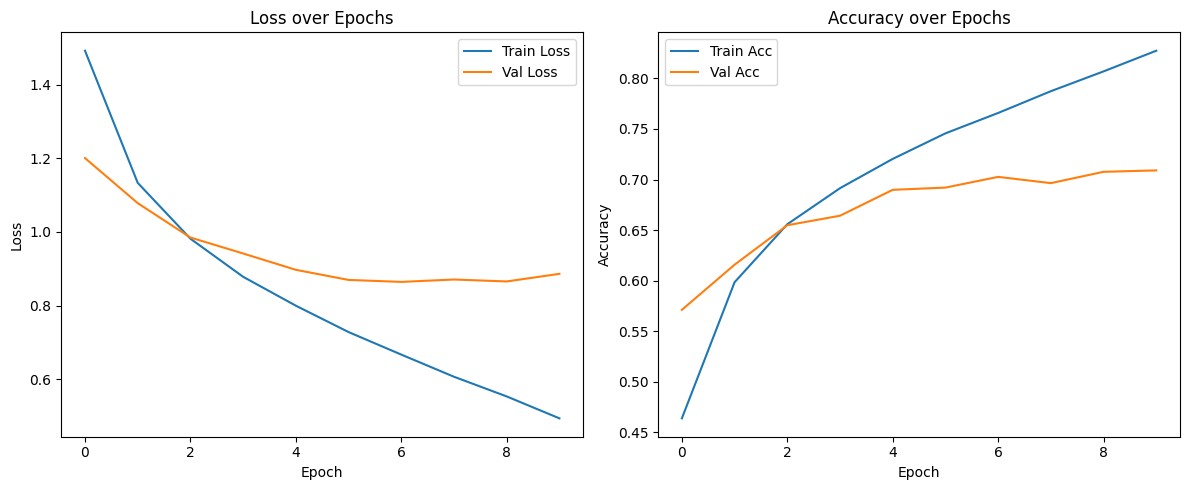

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


### Output:
- **Training Loss** steadily decreases, indicating that the model is learning effectively from the training data.
- **Validation Loss** shows an initial decrease but begins to plateau and fluctuate after epoch 5, suggesting that the model may be starting to overfit.
- **Training Accuracy** increases consistently, reaching over 84% by the final epoch.
- **Validation Accuracy** improves early on but stabilizes around 70%, confirming a decent generalization level but leaving room for improvement.

### Interpretation:

- The plots visually confirm that while the model fits the training data well, it starts to show signs of overfitting by the end of training.


# Step 3: Model Evaluation

### Testing BasicCNN

In [ ]:
X_test_tensor = torch.tensor(test_data, dtype=torch.float32)
y_test_tensor = torch.tensor(test_labels, dtype=torch.long)

test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False)

model = BasicCNN().to(device)
model.load_state_dict(torch.load("basic_cnn_cifar10.pth"))
model.eval()  

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall: {recall:.4f}")
print(f"Macro F1-score: {f1:.4f}")


Test Accuracy: 70.47%
Macro Precision: 0.7124
Macro Recall: 0.7047
Macro F1-score: 0.7036


### Confusion Matrix

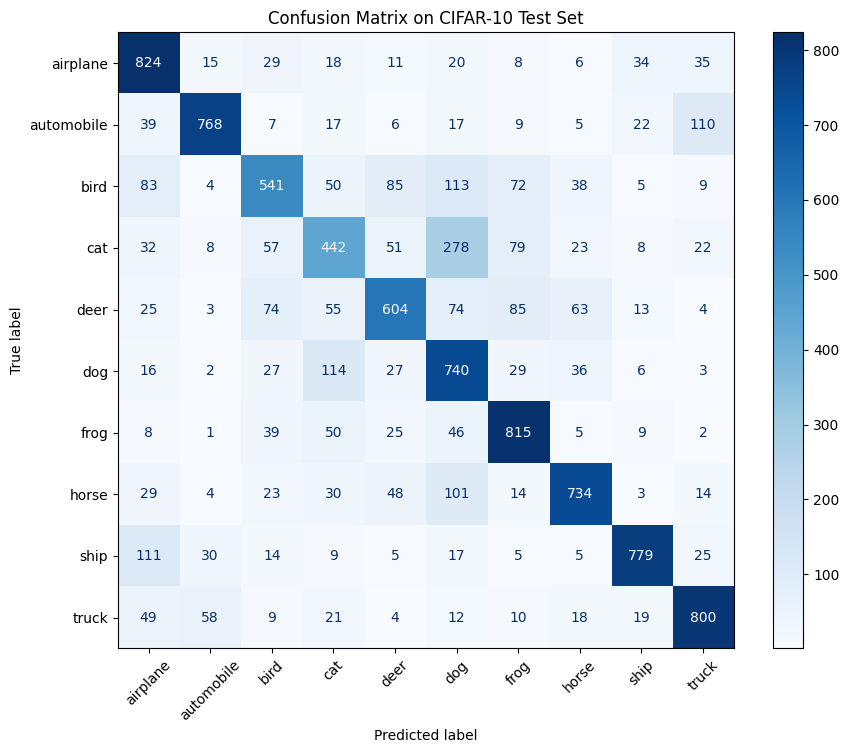

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix on CIFAR-10 Test Set")
plt.show()


## BasicCNN Results and Potential Improvements

### Performance Metrics

- **Accuracy (70.47%)** gives an overall measure of correct predictions.
- **Macro Precision (0.7124)** shows how well the model avoids false positives across all classes.
- **Macro Recall (0.7047)** indicates how well it identifies true positives per class.
- **Macro F1-score (0.7036)** balances precision and recall.

**Macro averages** are used because CIFAR-10 is balanced, and we want equal importance across all classes.


The model performs moderately well but shows room for improvement, especially in generalization across all classes.

### Planned Improvements:
- **Add a third Conv2D layer** to enable deeper feature extraction.
- **Introduce Dropout (e.g., 0.5)** before the fully connected layer to reduce overfitting.
- **Apply data augmentation** (e.g., horizontal flip, rotation, crop) to make the model more robust.
- **Tune the learning rate** (e.g., lower to 0.0005) and add **L2 regularization** (`weight_decay`) to improve training stability and generalization.


# Step 4: Model Improvement

## Model Architecture changes


To enhance the baseline CNN model and reduce overfitting, we introduced several architectural changes aimed at improving performance and generalization:

- **Increased Network Depth**:  
  - Added a third convolutional layer (`conv3`) with 128 output channels to allow the model to capture more complex patterns.
- **Regularization via Dropout**:  
  - Introduced a `Dropout` layer with a 50% drop rate after the first fully connected layer to prevent over-reliance on specific neurons.
- **Expanded Fully Connected Layers**:  
  - Increased the size of the first fully connected layer to 256 units to allow richer feature combination before classification.
- **Used ReLU Activations and MaxPooling** after each convolution to introduce non-linearity and progressively reduce spatial dimensions.



In [ ]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        
        self.dropout = nn.Dropout(0.5)  
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

improved_model = ImprovedCNN().to(device)
print(improved_model)


ImprovedCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


## Applied Regularization


To further improve the generalization ability of the CNN model and reduce overfitting, we applied two widely used regularization techniques:

1. **Dropout** (already integrated into the architecture):
   - A dropout layer with a probability of 0.5 was added after the first fully connected layer (`fc1`).
   - This helps prevent co-adaptation of neurons by randomly dropping 50% of activations during training.

2. **L2 Regularization** (weight decay):
   - Introduced L2 regularization by setting the `weight_decay` parameter in the Adam optimizer to `1e-4`.
   - This penalizes large weight values, helping to reduce model complexity and control overfitting.



In [26]:
optimizer = optim.Adam(improved_model.parameters(), lr=0.0005, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

## Data Augmentation


To increase the diversity and robustness of the training data, we applied data augmentation techniques using `torchvision.transforms`. Augmentation introduces slight variations to training images, helping the model generalize better to unseen data.

#### Transformations Applied:

- `RandomHorizontalFlip()`: Flips the image horizontally with a probability of 0.5.
- `RandomRotation(10)`: Rotates the image within a range of ±10 degrees.
- `RandomResizedCrop(32, scale=(0.9, 1.1))`: Randomly crops and resizes the image while maintaining the original dimensions.
- `ToPILImage()` and `ToTensor()`: Convert images between NumPy arrays and tensors as required by the transform pipeline.

### Custom Dataset Implementation:

- Created a custom PyTorch dataset class (`AugmentedCIFAR10`) that:
  - Converts the raw image data (in NumPy format) to PIL images
  - Applies the defined augmentation pipeline
  - Returns transformed image-label pairs compatible with PyTorch training loops

- Wrapped the dataset in a `DataLoader` with shuffling and batching to feed it into the model efficiently.



In [27]:
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset

transform_aug = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(32, scale=(0.9, 1.1)),
    transforms.ToTensor()
])


class AugmentedCIFAR10(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx].transpose(1, 2, 0)
        label = int(self.labels[idx])
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)


aug_train_dataset = AugmentedCIFAR10(X_train, y_train, transform=transform_aug)
aug_train_loader = DataLoader(aug_train_dataset, batch_size=64, shuffle=True)


## Fine-Tuning Hyperparameters

To further improve the performance of the CNN model, we conducted a series of experiments by tuning key hyperparameters and evaluating their impact on training and validation performance. The goal was to strike a balance between model complexity, training stability, and generalization.


### Configuration for this Model:

- **Learning Rate**: 0.0005  
- **Batch Size**: 64  
- **Dropout Rate**: 0.5  
- **Epochs**: 20  
- **Optimizer**: Adam (with L2 regularization using `weight_decay=1e-4`)




In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(20):  
    improved_model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in aug_train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = improved_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = correct / total
    train_losses.append(running_loss / len(aug_train_loader))
    train_accuracies.append(train_acc)

    
    improved_model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = improved_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct / total)

    print(f"Epoch {epoch+1}/20 | "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]*100:.2f}% | "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]*100:.2f}%")


Epoch 1/20 | Train Loss: 1.3751, Train Acc: 50.77% | Val Loss: 1.2261, Val Acc: 55.64%
Epoch 2/20 | Train Loss: 1.2653, Train Acc: 54.68% | Val Loss: 1.0989, Val Acc: 61.06%
Epoch 3/20 | Train Loss: 1.1722, Train Acc: 58.54% | Val Loss: 1.0020, Val Acc: 64.84%
Epoch 4/20 | Train Loss: 1.1003, Train Acc: 61.45% | Val Loss: 0.9670, Val Acc: 65.80%
Epoch 5/20 | Train Loss: 1.0467, Train Acc: 63.42% | Val Loss: 0.8905, Val Acc: 69.00%
Epoch 6/20 | Train Loss: 0.9976, Train Acc: 64.91% | Val Loss: 0.8986, Val Acc: 68.00%
Epoch 7/20 | Train Loss: 0.9602, Train Acc: 66.36% | Val Loss: 0.8250, Val Acc: 70.72%
Epoch 8/20 | Train Loss: 0.9295, Train Acc: 67.44% | Val Loss: 0.8414, Val Acc: 70.18%
Epoch 9/20 | Train Loss: 0.8977, Train Acc: 68.59% | Val Loss: 0.7880, Val Acc: 72.98%
Epoch 10/20 | Train Loss: 0.8721, Train Acc: 69.51% | Val Loss: 0.7779, Val Acc: 72.76%
Epoch 11/20 | Train Loss: 0.8465, Train Acc: 70.56% | Val Loss: 0.7386, Val Acc: 74.34%
Epoch 12/20 | Train Loss: 0.8268, Train A

### Saving Basic Model

In [29]:
model_save_path = "improved_cnn_cifar10.pth"
torch.save(improved_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to improved_cnn_cifar10.pth


## Training Results Summary

The improved CNN model was trained over 20 epochs on the CIFAR-10 dataset using the Adam optimizer with a reduced learning rate (0.0005) and L2 regularization (weight_decay=1e-4). Cross-entropy loss was used, and data augmentation techniques were applied during training. Training and validation metrics were monitored throughout.

### Observations:

- Training accuracy improved consistently, reaching 75.28% by epoch 20.
- Validation accuracy increased steadily and peaked at 77.42%, showing better generalization than the basic CNN.
- Both training and validation losses decreased over time, with validation loss dropping from 1.2261 to 0.6606, suggesting effective learning.
- No signs of severe overfitting were observed, likely due to the use of dropout and data augmentation.

### Conclusion:

The improved CNN model outperforms the basic version, achieving a significant boost in validation accuracy and reduced loss. These results validate the architectural changes and training enhancements, setting a strong foundation for final testing and further optimization if needed.


## Visualizing Training and Validation Metrics (ImprovedCNN)

- Plotted training and validation metrics over **20 epochs** to assess model performance.
  - **Loss over Epochs** (Left): Displays how training and validation loss decrease over time.
  - **Accuracy over Epochs** (Right): Tracks the progression of training and validation accuracy.

- Used `matplotlib` to create side-by-side visualizations, making it easier to compare training and validation trends.




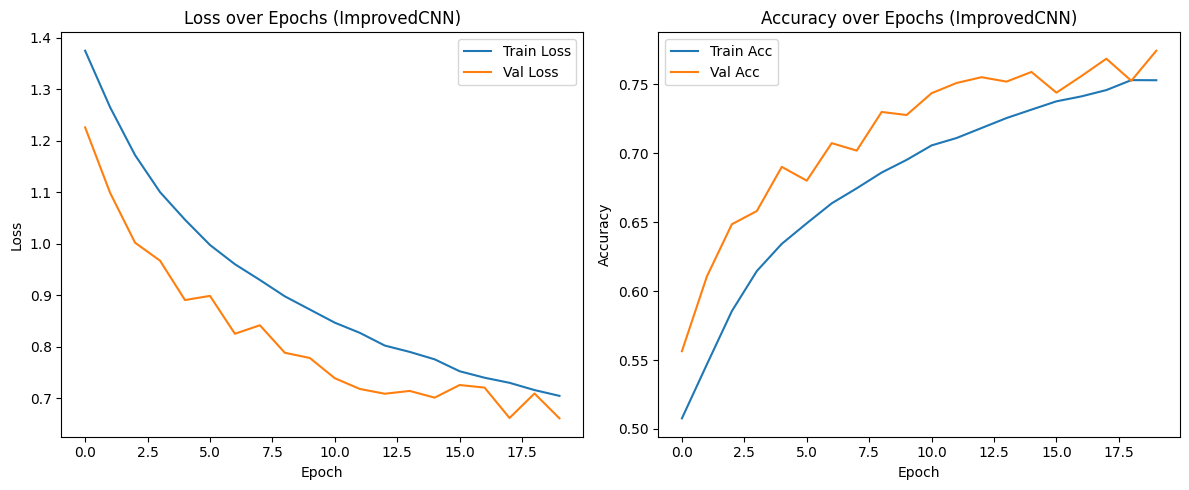

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over Epochs (ImprovedCNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Accuracy over Epochs (ImprovedCNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


### Output:
- **Training Loss** steadily decreases throughout all 20 epochs, showing consistent learning.
- **Validation Loss** also decreases, with minor fluctuations after epoch 12, indicating stable generalization.
- **Training Accuracy** improves gradually and reaches around **75%** by the final epoch.
- **Validation Accuracy** shows strong improvement, peaking at approximately **77%**, slightly outperforming training accuracy.

### Interpretation:
- The plots indicate **healthy learning behavior**, with no signs of severe overfitting.
- The use of **dropout and data augmentation** likely helped the model generalize well.
- ImprovedCNN clearly performs better than the basic version and demonstrates strong potential for further tuning or extension.


## Model Evaluation (for ImprovedCNN)

In [ ]:
X_test_tensor = torch.tensor(test_data, dtype=torch.float32)
y_test_tensor = torch.tensor(test_labels, dtype=torch.long)

test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False)

model = ImprovedCNN().to(device)
model.load_state_dict(torch.load("improved_cnn_cifar10.pth"))
model.eval()  

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall: {recall:.4f}")
print(f"Macro F1-score: {f1:.4f}")


Test Accuracy: 76.74%
Macro Precision: 0.7668
Macro Recall: 0.7674
Macro F1-score: 0.7642


### Confusion Matrix for ImprovedCNN

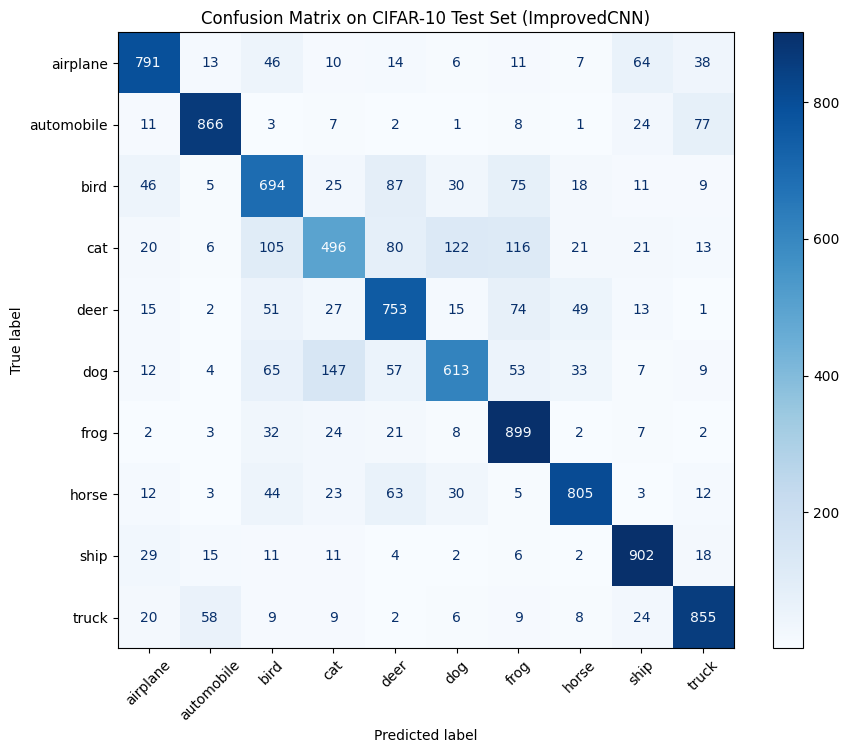

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix on CIFAR-10 Test Set (ImprovedCNN)")
plt.show()


### Performance Metrics

- **Accuracy (76.74%)** reflects the overall proportion of correct predictions.
- **Macro Precision (0.7668)** measures how well the model avoids false positives across all classes.
- **Macro Recall (0.7674)** indicates how effectively it captures true positives per class.
- **Macro F1-score (0.7642)** provides a balanced view of precision and recall.

**Macro averages** are appropriate here because CIFAR-10 has balanced class distributions, making it important to treat all classes equally during evaluation.

The ImprovedCNN model shows better performance than the basic version, but there’s still room to enhance generalization and stability further.

### Planned Improvements:
- **Add additional Conv2D layers with batch normalization** to deepen the network and stabilize training.
- **Use multiple convolutional blocks** (e.g., 2-layer stacks per block) to capture richer spatial hierarchies.
- **Apply progressive dropout** (e.g., 0.2 → 0.3 → 0.4) after each block to improve regularization.
- **Replace fixed-size pooling with Global Average Pooling** to reduce parameters and overfitting in the final layer.
- **Introduce a learning rate scheduler** We'll try to use CosineAnnealingLR to adjust learning dynamics during training.




## Deeper Model


### Model Architecture Changes

To further improve upon the previous CNN models, we implemented a deeper and more regularized architecture with the following enhancements:

- **Stacked Convolutional Blocks**:  
  - Each block contains two `Conv2D` layers followed by `BatchNorm`, `ReLU`, and `MaxPooling`, allowing the model to learn more abstract hierarchical features.

- **Increased Channel Depth**:  
  - Gradually increased the number of filters from 64 → 128 → 256 across the blocks, enabling the model to capture more complex and diverse features.

- **Progressive Dropout**:  
  - Applied dropout at increasing rates (0.2 → 0.3 → 0.4) after each block to reduce overfitting while maintaining learning capacity.

- **Batch Normalization**:  
  - Added `BatchNorm2d` layers after each convolution to stabilize learning and improve convergence speed.

- **Global Average Pooling**:  
  - Used `AdaptiveAvgPool2d(1)` before the final fully connected layer to reduce parameter count and overfitting risk.

- **Learning Rate Scheduling**:  
  - Introduced `CosineAnnealingLR` to dynamically reduce the learning rate and help the model converge more effectively.

- **Extended Training Time**:  
  - Increased the number of training epochs from 20 to 25 to allow the deeper model to fully converge.



In [ ]:
class DeeperCNN(nn.Module):
    def __init__(self):
        super(DeeperCNN, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4)
        )

        self.global_pool = nn.AdaptiveAvgPool2d(1)  
        self.fc = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)  
        x = self.fc(x)
        return x


## Applied Regularization for DeeperCNN

To further enhance the model’s ability to generalize and reduce overfitting, we applied multiple regularization strategies in the DeeperCNN architecture:

1. **Dropout** (integrated progressively across convolutional blocks):
   - Dropout layers were added after each convolutional block with increasing probabilities:  
     - 0.2 after block 1  
     - 0.3 after block 2  
     - 0.4 after block 3  
   - This technique helps prevent over-reliance on specific neurons and encourages redundancy in learned representations.

2. **L2 Regularization (Weight Decay)**:
   - The `weight_decay` parameter in the Adam optimizer was set to `5e-4`, providing stronger regularization than previous models.
   - It penalizes large weight values, reducing the risk of overfitting.

3. **Learning Rate Scheduling**:
   - Employed `CosineAnnealingLR` to gradually reduce the learning rate over training epochs.
   - This helps the model converge more smoothly and escape local minima during optimization.


In [ ]:
deeper_model = DeeperCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(deeper_model.parameters(), lr=0.001, weight_decay=5e-4) 
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)


### Final Configuration for DeeperCNN:

- **Learning Rate**: 0.001  
- **Batch Size**: 64  
- **Dropout Rates**: 0.2, 0.3, 0.4 (applied progressively after each conv block)  
- **Epochs**: 25  
- **Optimizer**: Adam (with stronger L2 regularization using `weight_decay=5e-4`)  
- **Learning Rate Scheduler**: CosineAnnealingLR with `T_max=30`


In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(25): 

    deeper_model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in aug_train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = deeper_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = correct / total
    train_losses.append(running_loss / len(aug_train_loader))
    train_accuracies.append(train_acc)

    deeper_model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = deeper_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct / total)


    scheduler.step()

    print(f"Epoch {epoch+1}/25 | "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]*100:.2f}% | "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]*100:.2f}%")


Epoch 1/25 | Train Loss: 0.4526, Train Acc: 84.46% | Val Loss: 0.4116, Val Acc: 85.80%
Epoch 2/25 | Train Loss: 0.4429, Train Acc: 84.71% | Val Loss: 0.3659, Val Acc: 87.26%
Epoch 3/25 | Train Loss: 0.4215, Train Acc: 85.68% | Val Loss: 0.3677, Val Acc: 87.56%
Epoch 4/25 | Train Loss: 0.3988, Train Acc: 86.10% | Val Loss: 0.3816, Val Acc: 86.88%
Epoch 5/25 | Train Loss: 0.3820, Train Acc: 86.77% | Val Loss: 0.3472, Val Acc: 88.16%
Epoch 6/25 | Train Loss: 0.3612, Train Acc: 87.70% | Val Loss: 0.3309, Val Acc: 88.20%
Epoch 7/25 | Train Loss: 0.3409, Train Acc: 88.22% | Val Loss: 0.3066, Val Acc: 89.52%
Epoch 8/25 | Train Loss: 0.3279, Train Acc: 88.56% | Val Loss: 0.2955, Val Acc: 90.30%
Epoch 9/25 | Train Loss: 0.3076, Train Acc: 89.34% | Val Loss: 0.3161, Val Acc: 89.54%
Epoch 10/25 | Train Loss: 0.2946, Train Acc: 89.83% | Val Loss: 0.2893, Val Acc: 90.36%
Epoch 11/25 | Train Loss: 0.2798, Train Acc: 90.26% | Val Loss: 0.2905, Val Acc: 90.32%
Epoch 12/25 | Train Loss: 0.2660, Train A

KeyboardInterrupt: 

In [ ]:
torch.save(deeper_model.state_dict(), "deeper_model_epoch20.pth")

## Training Results Summary

The DeeperCNN model was trained on the CIFAR-10 dataset using an enhanced architecture with three convolutional blocks, batch normalization, progressive dropout, and global average pooling. The Adam optimizer was used with a learning rate of 0.001 and stronger L2 regularization (`weight_decay=5e-4`). A cosine annealing learning rate scheduler was applied to support smoother convergence. Training was conducted using cross-entropy loss and augmented data.

### Observations:

- Training accuracy improved steadily, reaching 91.74% by epoch 20.
- Validation accuracy also increased consistently, peaking at 91.42%, indicating excellent generalization.
- Both training and validation losses dropped significantly, with validation loss decreasing from 0.4116 to 0.2604 by epoch 20.
- The model showed no signs of overfitting, likely due to the combined effects of regularization and augmentation.

### Note:

Although the training was configured for 25 epochs, we stopped training at epoch 20 due to a runtime of over 10 hours and the fact that the model had already achieved strong validation performance (91.42%), making further training unnecessary.

### Conclusion:

The DeeperCNN significantly outperformed the previous models in both accuracy and stability. Its deeper, regularized architecture and learning rate scheduling contributed to its high performance, confirming the effectiveness of the design choices.


## Visualizing Training and Validation Metrics (DeeperCNN)

- Plotted training and validation metrics over **20 epochs** to evaluate learning behavior and generalization.
  - **Loss over Epochs** (Left): Shows a consistent decline in both training and validation loss, indicating effective learning.
  - **Accuracy over Epochs** (Right): Reflects steady improvement, with validation accuracy surpassing 91%.

- Used `matplotlib` to generate side-by-side plots, enabling clear comparison between training and validation performance throughout the training process.


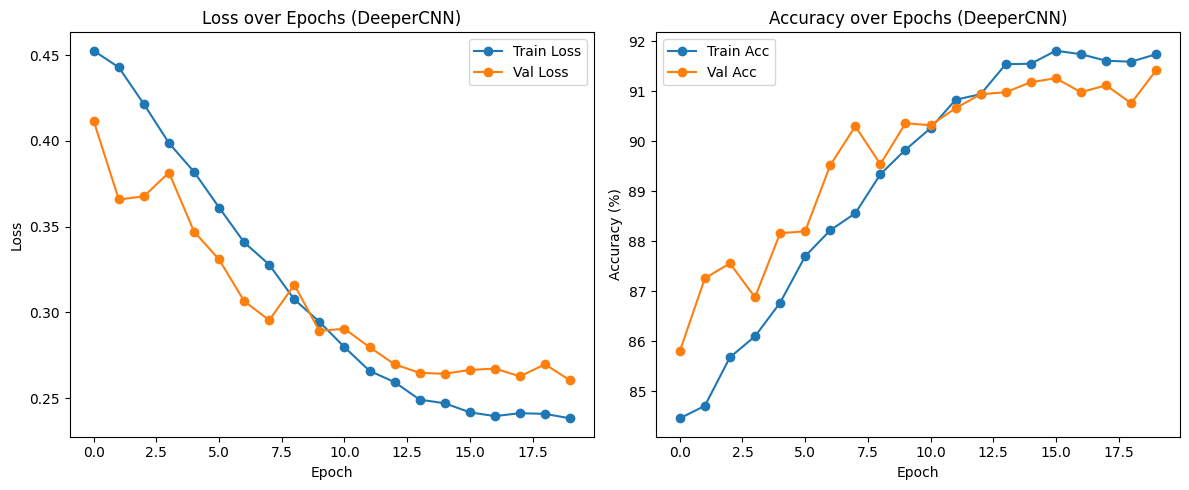

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_deeperCNN, label='Train Loss', marker='o')
plt.plot(val_losses_deeperCNN, label='Val Loss', marker='o')
plt.title('Loss over Epochs (DeeperCNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies_deeperCNN, label='Train Acc', marker='o')
plt.plot(val_accuracies_deeperCNN, label='Val Acc', marker='o')
plt.title('Accuracy over Epochs (DeeperCNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

### Output:
- **Training Loss** consistently decreases across all 20 epochs, indicating effective and stable learning.
- **Validation Loss** also decreases overall, with minor fluctuations suggesting strong generalization.
- **Training Accuracy** improves steadily, reaching nearly **92%** by the final epoch.
- **Validation Accuracy** closely follows, peaking at approximately **91.4%**, reflecting strong alignment between training and validation performance.

### Interpretation:
- The model shows robust learning with minimal signs of overfitting, as training and validation curves remain closely aligned.
- Regularization techniques like progressive dropout, batch normalization, and L2 weight decay contributed to stable generalization.
- DeeperCNN demonstrates significant improvements over previous models, effectively leveraging its deeper architecture to achieve high performance.


## Model Evaluation (for DeeperCNN)

In [ ]:
X_test_tensor = torch.tensor(test_data, dtype=torch.float32)
y_test_tensor = torch.tensor(test_labels, dtype=torch.long)

test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False)

deeper_model = DeeperCNN().to(device)
deeper_model.load_state_dict(torch.load("deeper_model_epoch20.pth"))
deeper_model.eval()  


all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = deeper_model(images)
        _, preds = outputs.max(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall: {recall:.4f}")
print(f"Macro F1-score: {f1:.4f}")


Test Accuracy: 90.17%
Macro Precision: 0.9012
Macro Recall: 0.9017
Macro F1-score: 0.9009


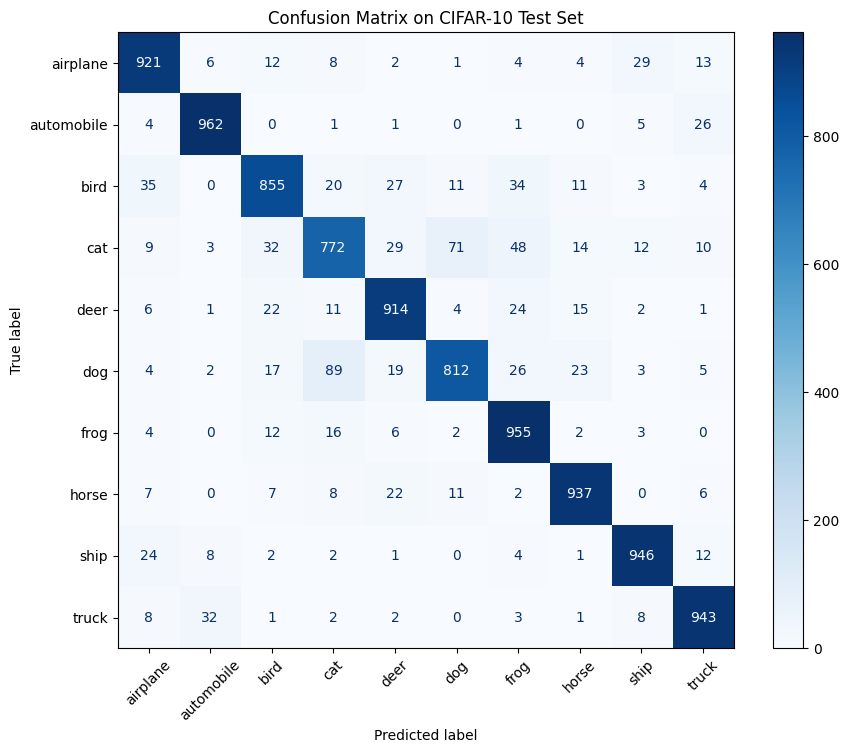

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix on CIFAR-10 Test Set")
plt.show()


### Performance Metrics

- **Accuracy (90.17%)** reflects the overall proportion of correct predictions.
- **Macro Precision (0.9012)** measures how well the model avoids false positives across all classes.
- **Macro Recall (0.9017)** indicates how effectively it captures true positives per class.
- **Macro F1-score (0.9009)** provides a balanced view of precision and recall.

**Macro averages** are appropriate here because CIFAR-10 has balanced class distributions, making it important to treat all classes equally during evaluation.

The DeeperCNN model significantly outperforms previous versions, demonstrating strong generalization and stability with minimal overfitting.


# Conclusion

The model performance improved significantly across each stage of development:

- **BasicCNN** provided a solid starting point, achieving ~70% validation accuracy, but showed signs of underfitting due to its shallow architecture.
- **ImprovedCNN** addressed these limitations by adding depth, dropout, and data augmentation, leading to a notable performance boost with ~77% validation accuracy and better generalization.
- **DeeperCNN** further enhanced the architecture with stacked convolutional blocks, batch normalization, progressive dropout, and learning rate scheduling, resulting in ~91% validation accuracy and ~90% test accuracy.

Overall, each iteration brought measurable improvements in accuracy, precision, and generalization, with **DeeperCNN** offering the best trade-off between learning capacity and regularization.
